This tutorial shows how to calculate noise for a time series using pyNA.

pyNA enables noise calculations in both python and julia. Select the preferred code language by setting the environment variable **before importing the pyna package**: 

``os.environ['pyna_language'] = 'python'``

``os.environ['pyna_language'] = 'julia'``

The inputs to the code are two excel sheets:
  - trajectory parameters
  - engine parameters

Follow the following steps: 

  1) load the standard settings for the nasa stca vehicle
    
  2) create a pyNA object
    
  3) call the ``pyna.compute_noise_time_series()`` method
    
Finally, the ``py.plot_noise_time_series()`` method plots the noise at the two certification microphones, for a selected noise metric (here: pnlt).



In [1]:
# Imports 
import os
import pdb
import numpy as np
import openmdao.api as om
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import clear_output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

os.environ["pyna_language"] = 'julia'
from pyNA.pyna import pyna

In [8]:
# Load verification trajectory
traj_nasa_std = pd.read_csv('../cases/nasa_stca_standard/trajectory/Trajectory_to.csv')
engine_nasa_std = pd.read_csv('../cases/nasa_stca_standard/engine/Engine_to.csv')

In [2]:
# Load default pyna settings 
if True:
    pyna_settings = pyna.load_settings(case_name ='nasa_stca_standard')
    pyna_settings.all_sources = True
    pyna_settings.validation = True
    pyna_settings.lateral_attenuation = False
    pyna_settings.engine_mounting = 'none'

    # pyna_settings.x_observer_array = np.array([[500., 450., 4*0.3048], [1000., 450., 4*0.3048]])

    # Start pyna
    py = pyna(settings=pyna_settings)

    # Compute noise
    py.compute_noise_time_series()


/Users/laurensvoet/Library/Python/3.7/lib/python/site-packages/openmdao/recorders/sqlite_recorder.py:224: UserWarning:The existing case recorder file, /Users/laurensvoet/Documents/Research/pyNA/pyNA/cases/nasa_stca_standard/dymos_solution.db, is being overwritten.


Model viewer data has already has already been recorded for Driver.


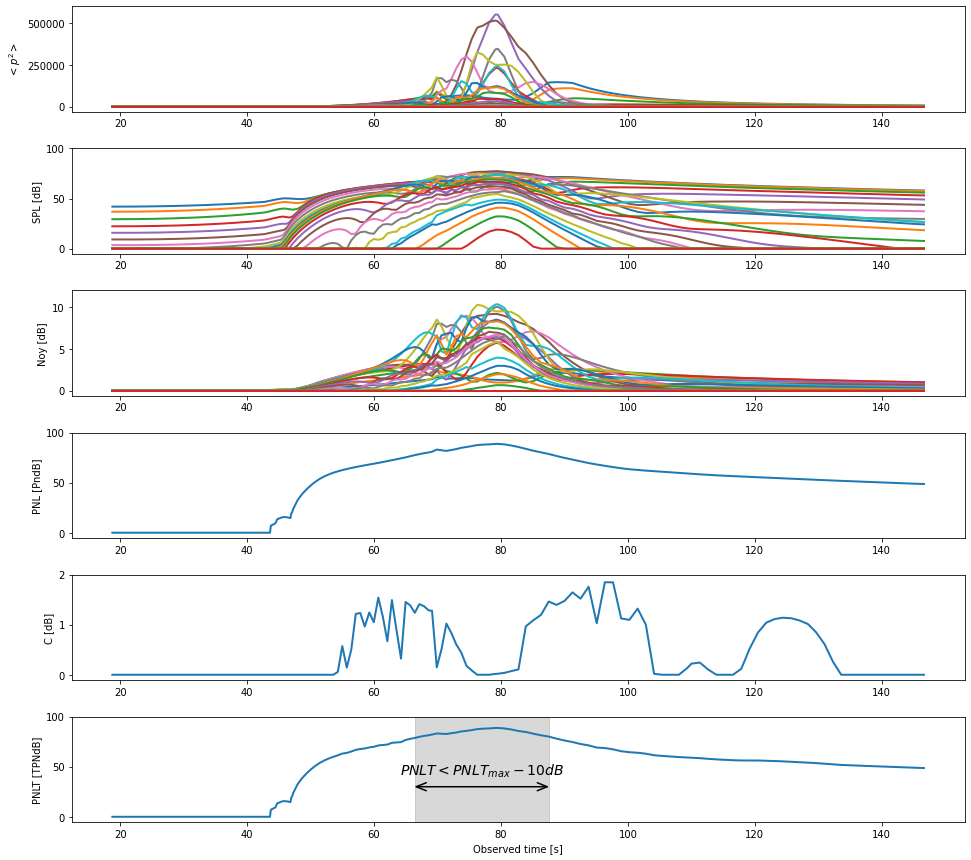

In [3]:
# Plot figure 
fig, ax = plt.subplots(6, 1, figsize=(16, 15))
plt.style.use('../utils/plot.mplstyle')

spl = py.problem.get_val('noise.levels.spl')[1,:,:]
rho_0 = py.problem.get_val('noise.levels.rho_0')
c_0 = py.problem.get_val('noise.levels.c_0')
p_ref = 2e-5
msap = np.zeros(np.shape(spl))
for i in np.arange(np.size(rho_0)):
    msap[i,:] = 10**((spl[i,:]-np.log10(rho_0[i]*2*c_0[i]**4/p_ref**2))/10)

ax[0].plot(py.problem.get_val('noise.geometry.t_o')[1,:], msap)
ax[0].set_ylabel('$<p^2>$')
ax[0].set_yticks([0, 250000, 500000])
ax[0].set_ylim([-30000, 600000])

ax[1].plot(py.problem.get_val('noise.geometry.t_o')[1,:], py.problem.get_val('noise.levels.spl')[1,:,:])
ax[1].set_ylabel('SPL [dB]')
ax[1].set_yticks([0, 50, 100])
ax[1].set_ylim([-5, 100])

ax[2].plot(py.problem.get_val('noise.geometry.t_o')[1,:], py.problem.get_val('noise.levels.noy')[1,:,:])
ax[2].set_ylabel('Noy [dB]')
ax[2].set_ylim([-0.6, 12])
ax[2].set_yticks([0, 5, 10])

ax[3].plot(py.problem.get_val('noise.geometry.t_o')[1,:], py.problem.get_val('noise.levels.pnl')[1,:])
ax[3].set_ylabel('PNL [PndB]')
ax[3].set_yticks([0, 50, 100])
ax[3].set_ylim([-5, 100])

ax[4].plot(py.problem.get_val('noise.geometry.t_o')[1,:], py.problem.get_val('noise.levels.c_max')[1,:])
ax[4].set_ylim([-0.1, 2])
ax[4].set_ylabel('C [dB]')
ax[4].set_yticks([0, 1, 2])

ax[5].plot(py.problem.get_val('noise.geometry.t_o')[1,:], py.problem.get_val('noise.levels.pnlt')[1,:])
ax[5].set_ylim([-5, 100])
ax[5].set_ylabel('PNLT [TPNdB]')
ax[5].set_xlabel('Observed time [s]')
ax[5].set_yticks([0, 50, 100])

pnlt = py.problem.get_val('noise.levels.pnlt')[1,:]
t_epnl = py.problem.get_val('noise.geometry.t_o')[1,:][np.where(pnlt > np.max(pnlt)-10)[0]]
ax[5].fill_between([t_epnl[0], t_epnl[-1]], [-5, -5], [100, 100], color='grey', alpha=0.3)
ax[5].annotate("",
              xy=(t_epnl[0]-0.4, 30), xycoords='data',
              xytext=(t_epnl[-1]+0.4, 30), textcoords='data',
              arrowprops=dict(arrowstyle="<->, head_length=1., head_width=0.4", connectionstyle="arc3", lw=1.5), )
ax[5].annotate(s="$PNLT < PNLT_{max} - 10 dB$", xy=(0.5*(t_epnl[0]+t_epnl[-1]), 42), ha='center', fontsize=14)

plt.subplots_adjust(hspace=0.35)

In [83]:
x_lst = np.linspace(-2000, 16000, 19)
y_lst = np.hstack((np.linspace(0, 450, 10), np.linspace(500, 4000, 12)))
py.compute_noise_contours(x_lst, y_lst)

/Users/laurensvoet/Library/Python/3.7/lib/python/site-packages/openmdao/recorders/sqlite_recorder.py:224: UserWarning:The existing case recorder file, /Users/laurensvoet/Documents/Research/pyNA/pyNA/cases/nasa_stca_standard/dymos_solution.db, is being overwritten.


Model viewer data has already has already been recorded for Driver.


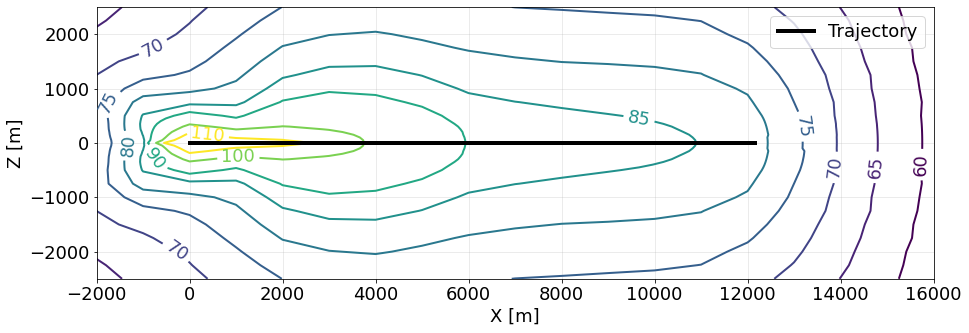

In [7]:
py.plot_noise_contours()

/Users/laurensvoet/Library/Python/3.7/lib/python/site-packages/mpl_toolkits/mplot3d/art3d.py:304: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



IndexError: index 2 is out of bounds for axis 0 with size 2

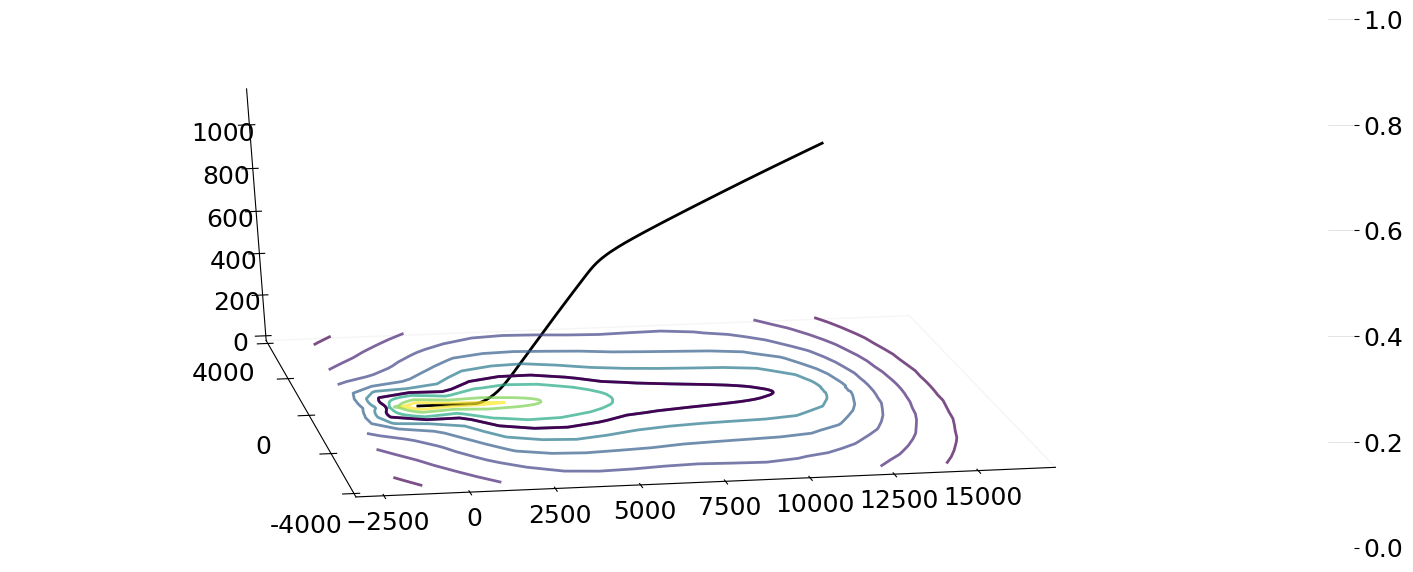

In [148]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(20,7))
ax = fig.add_subplot(111, projection='3d')

ax.view_init(elev=30, azim=260)
# ax.set_xlim([-3000, 15000])
ax.set_ylim([-4000, 4000])
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.set_yticks([-4000, -2000, 0, 2000, 4000])
ax.set_yticklabels([-4000,None, 0, None,4000])
# plt.set_ylim([-3900, 3900])
ax.tick_params(axis='y', pad=15)
# ax.set_zticks([])

CS = plt.contour(py.noise.contour['X'], py.noise.contour['Y'], py.noise.contour['epnl'], zdir='z', offset=0, levels=[60, 65, 70, 75, 80, 85, 90, 100, 110], alpha=0.7)

CS = plt.contour(py.noise.contour['X'], py.noise.contour['Y'], py.noise.contour['epnl'], zdir='z', offset=0, levels=[85], alpha=1)

ax.plot(traj_nasa_std['X [m]'], traj_nasa_std['Y [m]'], traj_nasa_std['Z [m]'], color='k')



# ax.get_zaxis().set_ticks([])
# ax.get_zaxis().line.set_linewidth(0)
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0)) # Hide YZ Plane
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0)) # Hide XZ Plane
ax.grid(False) # HIde All Gridlines

plt.colorbar()

In [3]:
# Load default pyna settings
if False:
    ac_name = 'a10'
    pyna_settings = pyna.load_settings(case_name =ac_name)
    pyna_settings.ac_name = ac_name

    pyna_settings.validation = True
    pyna_settings.lateral_attenuation = False
    pyna_settings.engine_mounting = 'none'

    pyna_settings.all_sources = True
    pyna_settings.fan_inlet = True
    pyna_settings.fan_discharge = False
    pyna_settings.core = False
    pyna_settings.jet_mixing = False
    pyna_settings.jet_shock = False 
    pyna_settings.airframe = False
    pyna_settings.levels_int_metric = 'epnl'
    pyna_settings.shielding = False

    pyna_settings.engine_file_name = 'engine_approach.csv'
    pyna_settings.trajectory_file_name = 'trajectory_approach.csv'
    pyna_settings.observer_lst = ('approach',)
    pyna_settings.x_observer_array = np.array([[-2291., 0., 4*0.3048], ])

    # Start pyna
    py = pyna(settings=pyna_settings)

    # Compute noise
    py.compute_noise_time_series()

    # Plot results
    py.plot_noise_time_series(metric='pnlt')

## Explore lateral attenuation methods

In [4]:
# Load default pyna settings 
n = 31
epnl_side = np.zeros((1,n))

x_iter = np.linspace(0, 6500, n)

for i,lat_att in enumerate([True]):

    for j,x in enumerate(x_iter):
    
        pyna_settings = pyna.load_settings(case_name ='stca')
        pyna_settings.output_directory_name = 'STCB/Vmax'
        pyna_settings.engine_file_name = 'engine_stca_25.0_0.4.csv'
        pyna_settings.trajectory_file_name = 'trajectory_stca_25.0_0.4.csv'
        pyna_settings.all_sources = True
        pyna_settings.validation = True
        pyna_settings.lateral_attenuation = lat_att
        pyna_settings.engine_mounting = 'underwing'
        pyna_settings.levels_int_metric = 'epnl'
        pyna_settings.groundeffects = True
        pyna_settings.absorption = True
        
        pyna_settings.observer_lst = ('lateral',)
        
        pyna_settings.x_observer_array = np.array([[x, 450., 4*0.3048],])
        
        # Start pyna
        py = pyna(settings=pyna_settings)
        
        # Compute noise
        py.compute_noise_time_series()

        # Plot results
        # py.plot_noise_time_series(metric='pnlt')
        epnl_side[i,j] = py.problem.get_val('noise.epnl')


/Users/laurensvoet/Library/Python/3.7/lib/python/site-packages/openmdao/recorders/sqlite_recorder.py:224: UserWarning:The existing case recorder file, /Users/laurensvoet/Documents/Research/pyNA/pyNA/cases/stca/dymos_solution.db, is being overwritten.


Model viewer data has already has already been recorded for Driver.
Model viewer data has already has already been recorded for Driver.
Model viewer data has already has already been recorded for Driver.
Model viewer data has already has already been recorded for Driver.
Model viewer data has already has already been recorded for Driver.
Model viewer data has already has already been recorded for Driver.
Model viewer data has already has already been recorded for Driver.
Model viewer data has already has already been recorded for Driver.
Model viewer data has already has already been recorded for Driver.
Model viewer data has already has already been recorded for Driver.
Model viewer data has already has already been recorded for Driver.
Model viewer data has already has already been recorded for Driver.
Model viewer data has already has already been recorded for Driver.
Model viewer data has already has already been recorded for Driver.
Model viewer data has already has already been r

In [6]:
no_lat = np.array([97.69410117, 96.57746028, 95.60085371, 94.77609173, 94.36612949,
       94.17191219, 94.0561012 , 93.96106806, 93.99434204, 94.35248297,
       94.9935095 , 96.46226934, 97.46833751, 97.19710667, 95.55578681,
       91.89338895, 89.5488245 , 88.86780542, 87.89295156, 87.36586802,
       86.53226874, 86.12590487, 85.89314425, 85.62668089, 85.37000324,
       85.34373575, 85.08600714, 84.83382763, 84.61641475, 84.40845224,
       84.26630601])

lat_no_accounting = np.array([90.67906702, 89.60061105, 88.66382917, 87.88085113, 87.51508681,
       87.36813691, 87.30361348, 87.26527744, 87.36275345, 87.79605009,
       88.52991013, 90.12690652, 91.37694546, 91.67372177, 90.79230362,
       87.87408909, 86.16303014, 86.03660532, 85.48680985, 85.34283161,
       84.79327619, 84.65829099, 84.63765039, 84.54923014, 84.46521961,
       84.57162866, 84.43955376, 84.30559977, 84.17890298, 84.06374614,
       84.00792054])

lat_accounting = np.array([94.68783001, 93.62037885, 92.8107752 , 91.92112469, 91.38512954,
       91.0789882 , 90.84085704, 90.76622412, 90.80304062, 90.9386575 ,
       91.06807549, 91.11074815, 90.99508015, 90.14387954, 87.9876954 ,
       85.86978864, 84.48852998, 83.77145557, 83.56388424, 83.50358366,
       83.46253537, 83.48607384, 83.66362913, 83.74082086, 83.79438493,
       83.82241989, 83.81924155, 83.81704325, 83.82713857, 83.68409665,
       83.66207524])


Text(0.5, 0, '$X_{sideline}$ [m]')

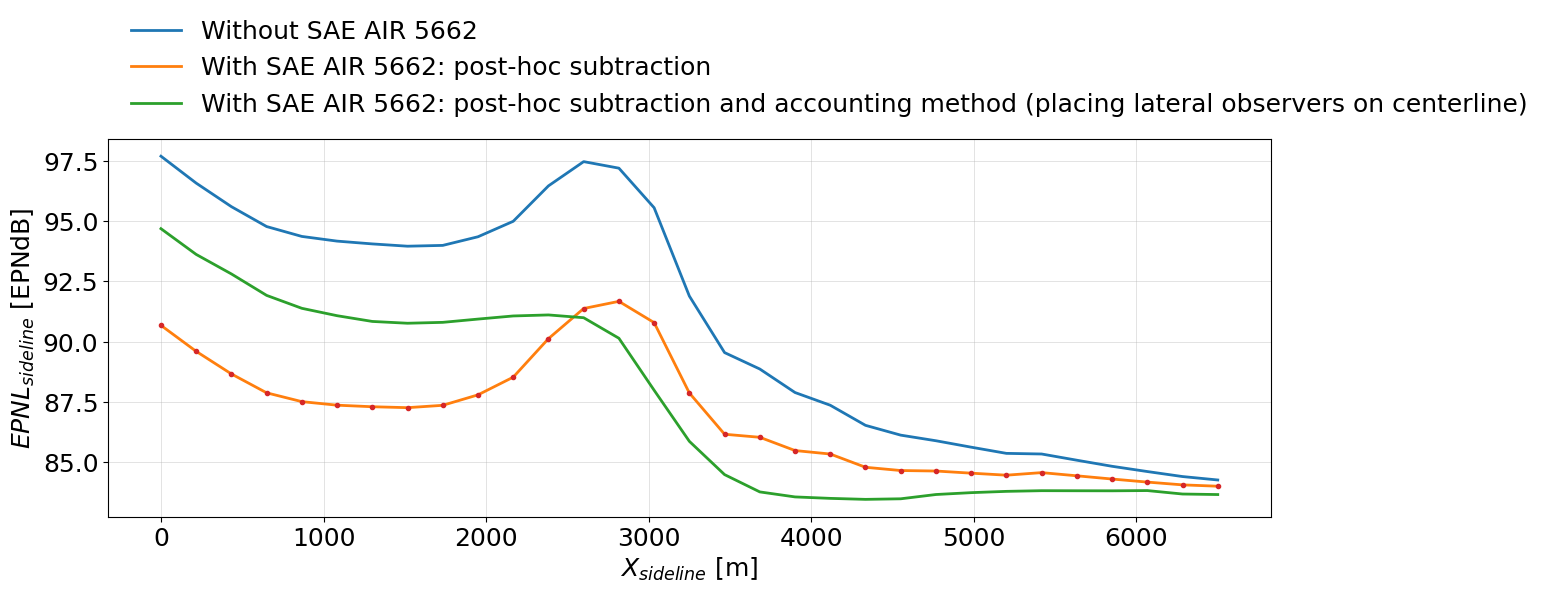

In [15]:
plt.figure(figsize=(15,5))
plt.style.use('../utils/plot.mplstyle')
plt.plot(x_iter, no_lat, label='Without SAE AIR 5662')
plt.plot(x_iter, lat_no_accounting, label='With SAE AIR 5662: post-hoc subtraction')
plt.plot(x_iter, lat_accounting, label='With SAE AIR 5662: post-hoc subtraction and accounting method (placing lateral observers on centerline)')

plt.plot(x_iter, epnl_side[0], 'o')
plt.legend(loc='lower left', bbox_to_anchor=(0, 1), frameon=False)
plt.ylabel('$EPNL_{sideline}$ [EPNdB]')
plt.xlabel('$X_{sideline}$ [m]')